# PTID-CDS-SEP-25-3140

# PRCP-1001 RiceLeaf
 1.mangesh rathod

2.shrikant gholap

# Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

In [ ]:
| **Feature**        | **Description**                                                                |
| ------------------ | ------------------------------------------------------------------------------ |
| `image_id`         | Unique identifier for each rice leaf image                                     |
| `image`            | Actual rice leaf image (RGB format, collected via field/lab conditions)        |
| `label` / `class`  | **Target variable**: Category of rice leaf condition (e.g., Healthy, Diseased) |
| `disease_type`     | Specific disease type (e.g., Bacterial Leaf Blight, Brown Spot, Leaf Smut)     |
| `width`            | Width of the image (in pixels)                                                 |
| `height`           | Height of the image (in pixels)                                                |
| `channel`          | Number of color channels (3 for RGB, 1 if converted to grayscale)              |
| `pixel_values`     | Pixel intensity values (matrix form)                                           |
| `augmented_image`  | Augmented image (rotated, flipped, zoomed, etc. for data balancing)            |
| `texture_features` | Extracted features (GLCM, color histograms, edge features, etc.)               |
| `shape_features`   | Leaf contour, shape, and size features (helpful for classification)            |
| `color_features`   | Mean/variance of green channel, color index ratios (indicate infection)        |
| `dataset_split`    | Whether the record belongs to **Train, Validation, or Test** set               |


# Importing the necessary libraries

In [16]:
import os, zipfile, random, shutil, io, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import tensorflow as tf
print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


# Download & Extract Dataset (directly from the problem statement link)

In [17]:
import requests

DATA_URL = "https://d3ilbtxij3aepc.cloudfront.net/projects/CDS-Capstone-Projects/PRCP-1001-RiceLeaf.zip"
ZIP_PATH = "PRCP-1001-RiceLeaf.zip"
EXTRACT_DIR = "dataset"

# Download if not present

In [18]:
if not os.path.exists(ZIP_PATH):
    print("Downloading dataset...")
    with requests.get(DATA_URL, stream=True) as r:
        r.raise_for_status()
        with open(ZIP_PATH, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 64):
                if chunk:
                    f.write(chunk)
    print("Download complete.")

# Extract the main zip file

In [19]:
if not os.path.exists(EXTRACT_DIR):
    print("Extracting main dataset zip...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)
    print("Main dataset extraction complete.")

# Now, find and extract any zip files within the 'Data' subdirectory
data_dir_path = os.path.join(EXTRACT_DIR, 'Data')
if os.path.exists(data_dir_path):
    print(f"Checking for zip files in {data_dir_path}...")
    for item in os.listdir(data_dir_path):
        item_path = os.path.join(data_dir_path, item)
        if os.path.isfile(item_path) and item.lower().endswith('.zip'):
            print(f"Extracting nested zip file: {item}")
            try:
                with zipfile.ZipFile(item_path, "r") as z:
                    z.extractall(data_dir_path) # Extract into the Data directory
                print(f"Extraction complete for {item}.")
            except zipfile.BadZipFile:
                print(f"Error: {item} is not a valid zip file.")
            # Optional: Remove the zip file after extraction if successful
            # os.remove(item_path)

Checking for zip files in dataset\Data...


# Try to infer the inner folder that holds class subfolders (Common layouts: dataset/RiceLeaf/*class* OR dataset/*class*)

In [20]:
def find_base_dir(root="dataset"):
    # first try dataset/RiceLeaf
    candidate = os.path.join(root, "RiceLeaf")
    if os.path.isdir(candidate) and len(os.listdir(candidate)) > 0:
        return candidate
    # else, find a directory that contains at least 3 subfolders with images
    for dirpath, dirnames, filenames in os.walk(root):
        # skip deep folders with images
        if dirpath == root:
            # check immediate subfolders as classes
            class_dirs = [d for d in dirnames if os.path.isdir(os.path.join(dirpath, d))]
            # heuristic: class dirs contain images
            valid = []
            for d in class_dirs:
                sub = os.path.join(dirpath, d)
                if any(f.lower().endswith((".jpg", ".jpeg", ".png")) for f in os.listdir(sub)):
                    valid.append(d)
            if len(valid) >= 3:
                return dirpath
    return root  # fallback

BASE_DIR = os.path.join(find_base_dir(EXTRACT_DIR), 'Data') # Point to the 'Data' subdirectory
print("Base directory (classes here):", BASE_DIR)
print("Subfolders:", os.listdir(BASE_DIR))



Base directory (classes here): dataset\Data
Subfolders: ['.ipynb_checkpoints', 'Bacterial leaf blight', 'Brown spot', 'Leaf smut']


# Exploratory Data Analysis (class counts, sample images)

In [21]:
classes = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])
print("Classes:", classes)

counts = {}
for c in classes:
    cdir = os.path.join(BASE_DIR, c)
    counts[c] = sum(1 for f in os.listdir(cdir) if f.lower().endswith((".jpg", ".jpeg", ".png")))
counts_df = pd.DataFrame.from_dict(counts, orient="index", columns=["count"]).sort_values("count", ascending=False)
counts_df

Classes: ['.ipynb_checkpoints', 'Bacterial leaf blight', 'Brown spot', 'Leaf smut']


,count
Bacterial leaf blight,40
Brown spot,40
Leaf smut,39
.ipynb_checkpoints,0


# Show one sample image per class

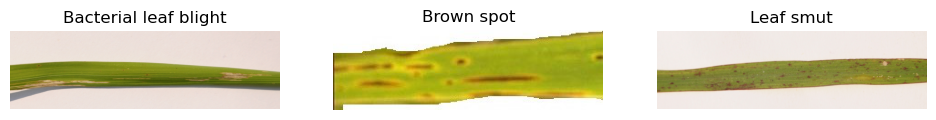

In [22]:
import matplotlib.image as mpimg

classes = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])
n = min(4, len(classes))
plt.figure(figsize=(4*n, 4))
for i, c in enumerate(classes[:n], 1):
    cdir = os.path.join(BASE_DIR, c)
    imgs = [f for f in os.listdir(cdir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not imgs:
        continue
    img_path = os.path.join(cdir, random.choice(imgs))
    img = mpimg.imread(img_path)
    plt.subplot(1, n, i)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")
plt.show()

# Data Generators with Augmentation Use a 70/30 split between train and val via validation_split

In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# Augmentation + preprocessing we'll use MobileNet preprocessing by default for generators

In [25]:
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False    # important for evaluation/reporting
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
class_indices, idx_to_class

Found 84 images belonging to 4 classes.
Found 35 images belonging to 4 classes.


({'.ipynb_checkpoints': 0,
  'Bacterial leaf blight': 1,
  'Brown spot': 2,
  'Leaf smut': 3},
 {0: '.ipynb_checkpoints',
  1: 'Bacterial leaf blight',
  2: 'Brown spot',
  3: 'Leaf smut'})

# Utility: plot training curves

In [27]:
def plot_curves(history, title="Training Curves"):
    plt.figure(figsize=(6,4))
    plt.plot(history.history.get('accuracy', []), label='train_acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history.get('loss', []), label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [28]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Model A — Simple CNN (from scratch)

In [29]:
cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

cnn.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()


C:\Users\Shree\.conda\anakona3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train CNN

C:\Users\Shree\.conda\anakona3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3333 - loss: 1.2682 - val_accuracy: 0.3143 - val_loss: 1.1928
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3810 - loss: 1.1254 - val_accuracy: 0.2857 - val_loss: 1.1072
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4524 - loss: 1.0734 - val_accuracy: 0.3714 - val_loss: 1.1374
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5000 - loss: 0.9799 - val_accuracy: 0.4000 - val_loss: 1.1379
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4643 - loss: 1.0207 - val_accuracy: 0.5143 - val_loss: 1.0670
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4524 - loss: 0.9773 - val_accuracy: 0.4857 - val_loss: 1.1000
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5952 - loss: 0.9223 - val_accuracy: 0.4286 - val_loss: 1.0185
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5714 - loss: 0.9606 - val_accuracy: 0.4286 - val_loss: 1.0667
Epoch 9/

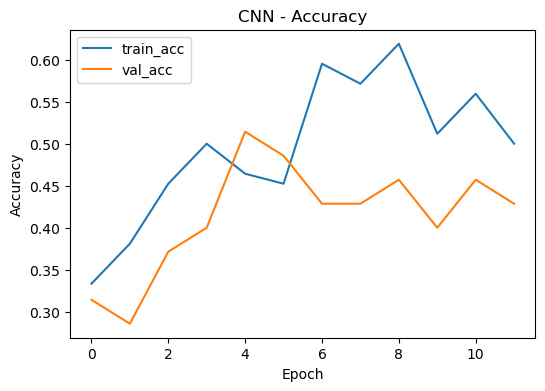

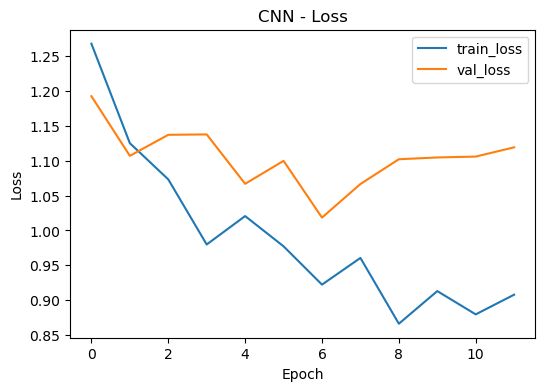

In [30]:
epochs_cnn = 12
history_cnn = cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_cnn,
    verbose=1
)

plot_curves(history_cnn, title="CNN")


# Evaluate CNN with classification report + confusion matrix

CNN Validation Classification Report:
                       precision    recall  f1-score   support

   .ipynb_checkpoints       0.00      0.00      0.00         0
Bacterial leaf blight       0.56      0.83      0.67        12
           Brown spot       0.73      0.67      0.70        12
            Leaf smut       0.17      0.09      0.12        11

             accuracy                           0.54        35
            macro avg       0.36      0.40      0.37        35
         weighted avg       0.49      0.54      0.50        35



C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\a

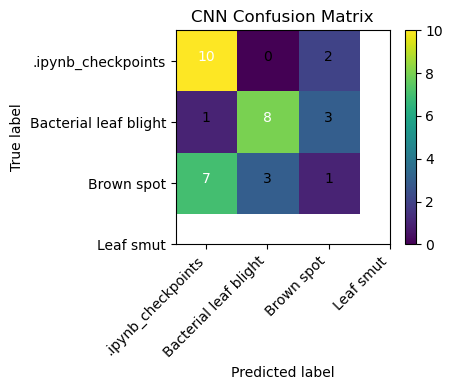

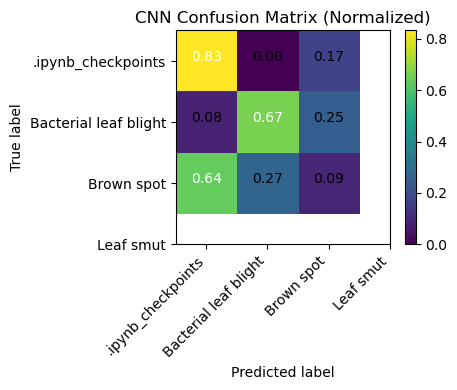

In [32]:
val_gen.reset()
y_true = val_gen.classes
y_pred = np.argmax(cnn.predict(val_gen, verbose=0), axis=1)

print("CNN Validation Classification Report:")
labels = [0, 1, 2, 3]  # or whatever your label encoding is
print(classification_report(y_true, y_pred, labels=labels, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes, title="CNN Confusion Matrix")
plot_confusion_matrix(cm, classes, normalize=True, title="CNN Confusion Matrix (Normalized)")


# Model B — Transfer Learning: MobileNetV2 (frozen base)

In [33]:
from tensorflow.keras.applications import MobileNetV2, ResNet50


In [34]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
mobilenet_base.trainable = False

mobilenet = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(len(classes), activation='softmax')
])

mobilenet.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train MobileNetV2 (frozen)

Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3690 - loss: 1.4892 - val_accuracy: 0.2000 - val_loss: 1.5734
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3095 - loss: 1.4349 - val_accuracy: 0.3143 - val_loss: 1.4234
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3810 - loss: 1.2974 - val_accuracy: 0.4000 - val_loss: 1.2206
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4286 - loss: 1.1784 - val_accuracy: 0.2000 - val_loss: 1.2580
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.3810 - loss: 1.2268 - val_accuracy: 0.3429 - val_loss: 1.1943
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4405 - loss: 1.1588 - val_accuracy: 0.4000 - val_loss: 1.1301
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5238 - loss: 1.0679 - val_accuracy: 0.4000 - val_loss: 1.1019
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5238 - loss: 1.0566 - val_accuracy: 0.4857 - val_loss: 1.0772
Epoch 9/

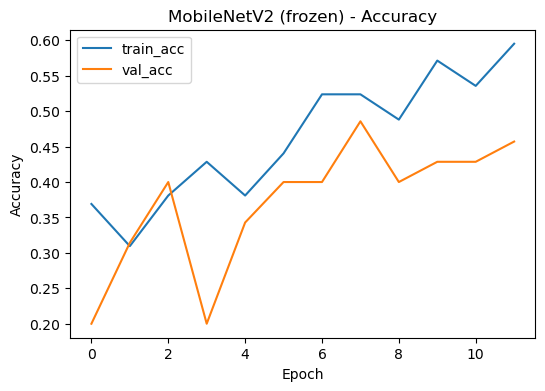

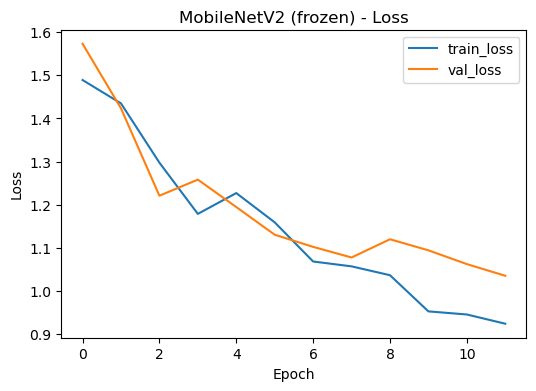

In [35]:
epochs_m = 12
history_m = mobilenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_m,
    verbose=1
)

plot_curves(history_m, title="MobileNetV2 (frozen)")


# Evaluate MobileNetV2

MobileNetV2 Validation Classification Report:
                       precision    recall  f1-score   support

   .ipynb_checkpoints       0.00      0.00      0.00         0
Bacterial leaf blight       1.00      0.58      0.74        12
           Brown spot       0.28      0.42      0.33        12
            Leaf smut       0.30      0.27      0.29        11

             accuracy                           0.43        35
            macro avg       0.39      0.32      0.34        35
         weighted avg       0.53      0.43      0.46        35



C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\a

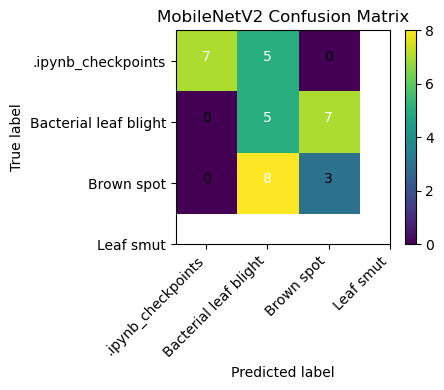

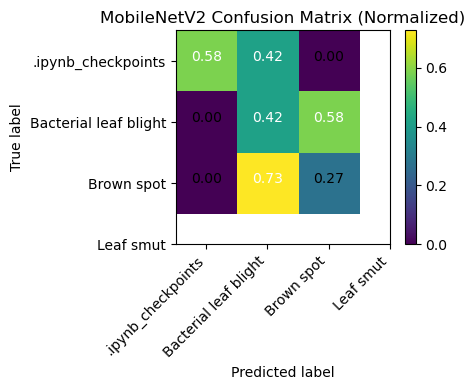

In [37]:
val_gen.reset()
y_true = val_gen.classes
y_pred_m = np.argmax(mobilenet.predict(val_gen, verbose=0), axis=1)

print("MobileNetV2 Validation Classification Report:")
labels = [0, 1, 2, 3]  # Adjust based on your encoding
print(classification_report(y_true, y_pred_m, labels=labels, target_names=classes))

cm_m = confusion_matrix(y_true, y_pred_m)
plot_confusion_matrix(cm_m, classes, title="MobileNetV2 Confusion Matrix")
plot_confusion_matrix(cm_m, classes, normalize=True, title="MobileNetV2 Confusion Matrix (Normalized)")


# Fine-tune MobileNetV2 last N layers Unfreeze a portion of the base model to fine-tune

In [38]:
FT_LAYERS = 30  # tune last 30 layers (adjust for your GPU/overfitting risk)
for layer in mobilenet_base.layers[-FT_LAYERS:]:
    layer.trainable = True

mobilenet.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,531,524 (5.84 MB)

 Non-trainable params: 731,584 (2.79 MB)

# Fine-tuning training

Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6548 - loss: 0.8623 - val_accuracy: 0.4286 - val_loss: 1.0268
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5119 - loss: 0.9814 - val_accuracy: 0.5429 - val_loss: 0.9611
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5595 - loss: 0.9587 - val_accuracy: 0.5714 - val_loss: 0.8938
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6310 - loss: 0.8817 - val_accuracy: 0.6286 - val_loss: 0.7901
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7262 - loss: 0.7017 - val_accuracy: 0.6286 - val_loss: 0.7897
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7024 - loss: 0.7108 - val_accuracy: 0.5714 - val_loss: 0.8831


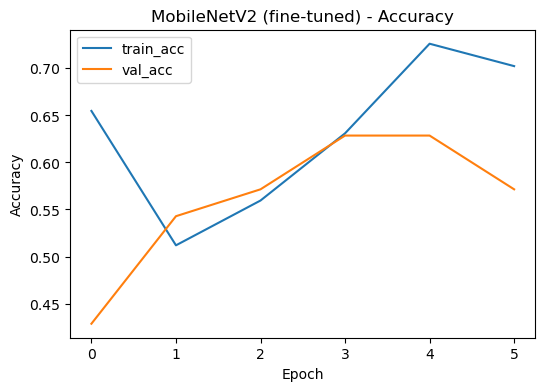

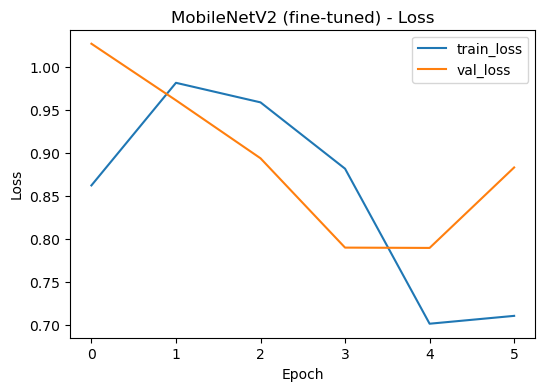

In [39]:
epochs_ft = 6
history_m_ft = mobilenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_ft,
    verbose=1
)

plot_curves(history_m_ft, title="MobileNetV2 (fine-tuned)")


MobileNetV2 (fine-tuned) Validation Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.88      0.58      0.70        12
           Brown spot       0.56      0.42      0.48        12
            Leaf smut       0.56      0.91      0.69        11

             accuracy                           0.63        35
            macro avg       0.66      0.64      0.62        35
         weighted avg       0.67      0.63      0.62        35



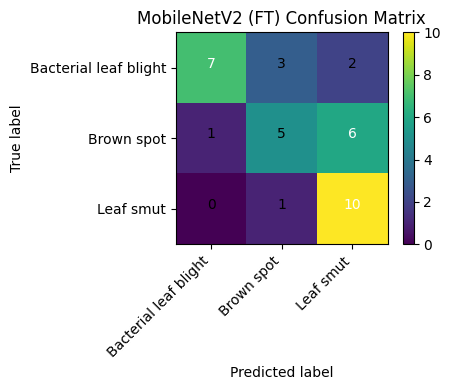

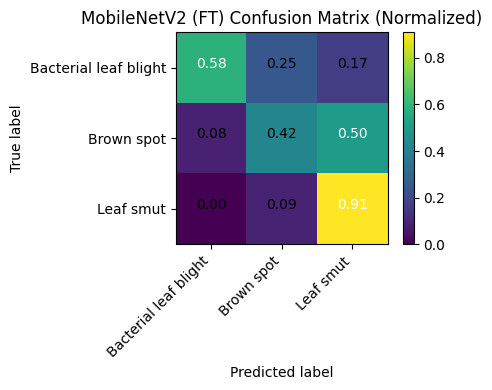

In [70]:
# Evaluate fine-tuned MobileNetV2
val_gen.reset()
y_true = val_gen.classes
y_pred_m_ft = np.argmax(mobilenet.predict(val_gen, verbose=0), axis=1)

print("MobileNetV2 (fine-tuned) Validation Classification Report:")
print(classification_report(y_true, y_pred_m_ft, target_names=classes))

cm_m_ft = confusion_matrix(y_true, y_pred_m_ft)
plot_confusion_matrix(cm_m_ft, classes, title="MobileNetV2 (FT) Confusion Matrix")
plot_confusion_matrix(cm_m_ft, classes, normalize=True, title="MobileNetV2 (FT) Confusion Matrix (Normalized)")


# Model C — Transfer Learning: ResNet50 (frozen base)

In [40]:

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess


In [41]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
resnet_base.trainable = False

resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(classes), activation='softmax')
])

resnet.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train ResNet50 (frozen)

Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.1310 - loss: 1.6261 - val_accuracy: 0.0286 - val_loss: 1.5138
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.2976 - loss: 1.4875 - val_accuracy: 0.2857 - val_loss: 1.4431
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1905 - loss: 1.5462 - val_accuracy: 0.2286 - val_loss: 1.4077
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3690 - loss: 1.4135 - val_accuracy: 0.3429 - val_loss: 1.3796
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3929 - loss: 1.3768 - val_accuracy: 0.3143 - val_loss: 1.3116
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3095 - loss: 1.4800 - val_accuracy: 0.2571 - val_loss: 1.2942
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3452 - loss: 1.3018 - val_accuracy: 0.2857 - val_loss: 1.2896
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3571 - loss: 1.3807 - val_accuracy: 0.3429 - val_loss: 1.2464
Epoch 9/

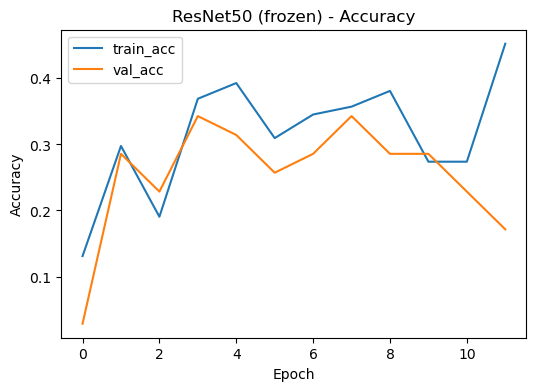

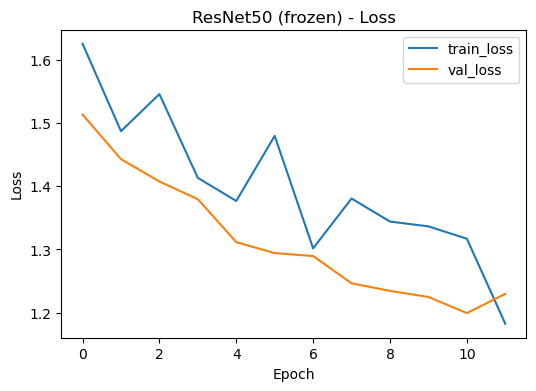

In [42]:
epochs_r = 12
history_r = resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_r,
    verbose=1
)

plot_curves(history_r, title="ResNet50 (frozen)")


# Evaluate ResNet50

ResNet50 Validation Classification Report:
                       precision    recall  f1-score   support

   .ipynb_checkpoints       0.00      0.00      0.00         0
Bacterial leaf blight       0.31      0.42      0.36        12
           Brown spot       0.32      0.50      0.39        12
            Leaf smut       0.00      0.00      0.00        11

             accuracy                           0.31        35
            macro avg       0.16      0.23      0.19        35
         weighted avg       0.22      0.31      0.26        35



C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\a

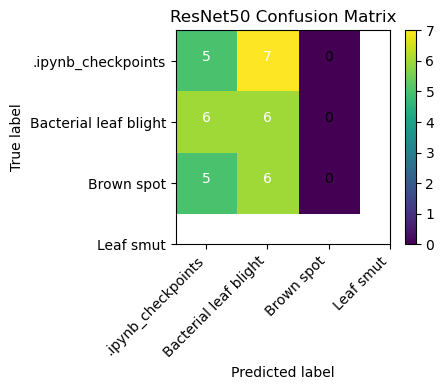

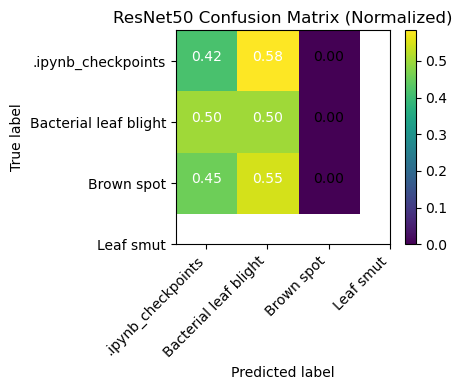

In [44]:
val_gen.reset()
y_true = val_gen.classes
y_pred_r = np.argmax(resnet.predict(val_gen, verbose=0), axis=1)

print("ResNet50 Validation Classification Report:")
labels = [0, 1, 2, 3]  # Adjust based on your encoding
print(classification_report(y_true, y_pred_r, labels=labels, target_names=classes))

cm_r = confusion_matrix(y_true, y_pred_r)
plot_confusion_matrix(cm_r, classes, title="ResNet50 Confusion Matrix")
plot_confusion_matrix(cm_r, classes, normalize=True, title="ResNet50 Confusion Matrix (Normalized)")


#  Fine-tune ResNet50 last N layers

In [45]:
FT_LAYERS_R = 20
for layer in resnet_base.layers[-FT_LAYERS_R:]:
    layer.trainable = True

resnet.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,939,524 (34.10 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

# Fine-tuning training for ResNet50

Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.2857 - loss: 1.2597 - val_accuracy: 0.1429 - val_loss: 1.2305
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3690 - loss: 1.1106 - val_accuracy: 0.2286 - val_loss: 1.2143
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4167 - loss: 1.1385 - val_accuracy: 0.2857 - val_loss: 1.2190
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4524 - loss: 1.1053 - val_accuracy: 0.2286 - val_loss: 1.2122
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5000 - loss: 1.0819 - val_accuracy: 0.2000 - val_loss: 1.2141
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5357 - loss: 0.9749 - val_accuracy: 0.2857 - val_loss: 1.2116


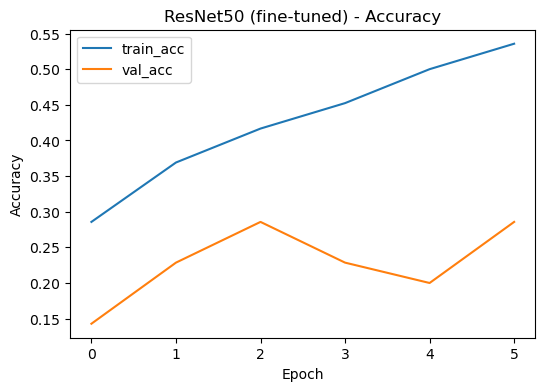

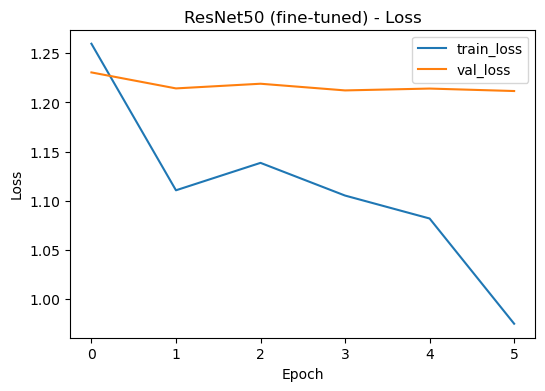

In [46]:
epochs_r_ft = 6
history_r_ft = resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_r_ft,
    verbose=1
)

plot_curves(history_r_ft, title="ResNet50 (fine-tuned)")


# Evaluate fine-tuned ResNet50

ResNet50 (fine-tuned) Validation Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.23      0.25      0.24        12
           Brown spot       0.18      0.33      0.24        12
            Leaf smut       0.00      0.00      0.00        11

             accuracy                           0.20        35
            macro avg       0.14      0.19      0.16        35
         weighted avg       0.14      0.20      0.16        35



C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shree\.conda\anakona3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


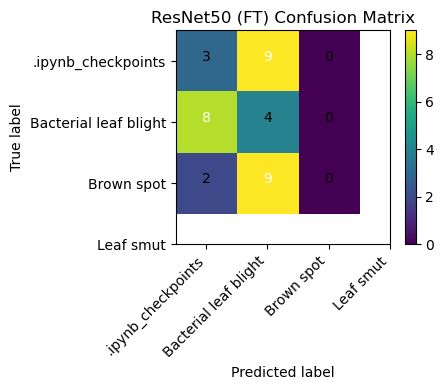

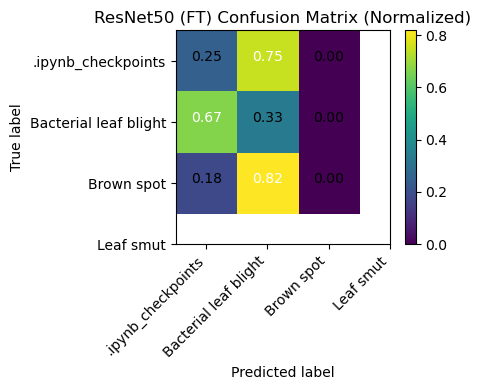

In [49]:
val_gen.reset()
y_true = val_gen.classes
y_pred_r_ft = np.argmax(resnet.predict(val_gen, verbose=0), axis=1)

print("ResNet50 (fine-tuned) Validation Classification Report:")
unique_labels = np.unique(y_true)
adjusted_classes = [classes[i] for i in unique_labels]

print(classification_report(y_true, y_pred_r_ft, target_names=adjusted_classes))


cm_r_ft = confusion_matrix(y_true, y_pred_r_ft)
plot_confusion_matrix(cm_r_ft, classes, title="ResNet50 (FT) Confusion Matrix")
plot_confusion_matrix(cm_r_ft, classes, normalize=True, title="ResNet50 (FT) Confusion Matrix (Normalized)")


# Model Comparison Table (using best val accuracy from each phase)

In [50]:
def best_val_acc(history):
    return float(np.max(history.history.get("val_accuracy", [0])))

rows = []
rows.append(["CNN (scratch)", best_val_acc(history_cnn)])

rows.append(["MobileNetV2 (frozen)", best_val_acc(history_m)])
if 'history_m_ft' in globals():
    rows.append(["MobileNetV2 (fine-tuned)", best_val_acc(history_m_ft)])

rows.append(["ResNet50 (frozen)", best_val_acc(history_r)])
if 'history_r_ft' in globals():
    rows.append(["ResNet50 (fine-tuned)", best_val_acc(history_r_ft)])

results_df = pd.DataFrame(rows, columns=["Model", "Best Val Accuracy"]).sort_values("Best Val Accuracy", ascending=False).reset_index(drop=True)
results_df


,Model,Best Val Accuracy
0,MobileNetV2 (fine-tuned),0.628571
1,CNN (scratch),0.514286
2,MobileNetV2 (frozen),0.485714
3,ResNet50 (frozen),0.342857
4,ResNet50 (fine-tuned),0.285714


# Save the best performing model (by current val accuracy on the val set) You can re-run evaluation to choose best y_pred, but here we pick by results_df

In [52]:
best_model_name = results_df.iloc[0, 0]
print("Best model by val accuracy:", best_model_name)

save_dir = Path("saved_models")
save_dir.mkdir(exist_ok=True, parents=True)

if "MobileNetV2 (fine-tuned)" in best_model_name:
    mobilenet.save(save_dir / "best_riceleaf_model.h5")
elif "MobileNetV2" in best_model_name:
    mobilenet.save(save_dir / "best_riceleaf_model.h5")
elif "ResNet50 (fine-tuned)" in best_model_name:
    resnet.save(save_dir / "best_riceleaf_model.h5")
elif "ResNet50" in best_model_name:
    resnet.save(save_dir / "best_riceleaf_model.h5")
else:
    cnn.save(save_dir / "best_riceleaf_model.h5")

print("Saved to:", save_dir / "best_riceleaf_model.h5")


Best model by val accuracy: MobileNetV2 (fine-tuned)
Saved to: saved_models\best_riceleaf_model.h5


# Challenges Faced & Solutions


1.**Small dataset size (≈120 images)**
  → Applied **data augmentation** (rotation, shift, zoom, flip) to increase effective variety.

2.**Overfitting risk**
  → Used **Dropout**, **frozen pretrained backbones**, and **early fine-tuning** with a lower learning rate.

3.**Inter-class similarity**
  → Leveraged deeper **transfer learning** models (MobileNetV2, ResNet50) to extract discriminative features.

4.**Compute constraints**
  → Started with **frozen base** for quick convergence; optionally fine-tuned last layers for extra boost.
